# Udacity Deep Reinforcement Learning Nanodegree
## Project 3 (Collaboration and Competition)

---

## Report

#### Learning Algorithm

The algorithm employed was the Deep Deterministic Policy Gradients (DDPG), which uses 2 groups of 2 twin Deep Neural Networks (DNN) to represent the Actor and Critic entities. These entities work together towards convergence of an approximation function applied on continuous action space scenarios, contributing with the tendency of high bias and high variance, respectively. The twin DNNs for each entity play a role of an 'effective' network (which provides the actual output for the entity) and a 'reference' network (which is used to keep weights with delayed updates, to avoid auto-referencing of the 'effective' network at learning time).

The DNNs architectures employed on each type of entity are similar, with 3 fully connected layers and 1 batch normalization between the 1st and 2nd layer. Also, ReLU activation function is employed on the output of the 1st and 2nd layers. The differences arise on the input and output for each architecture: the Actor (as the main entity) gets the states as input and the actions as output (as would be with a regular DQN algorithm); the Critic gets the states as primary input, but also the actions as a secondary input (injected directly on the 2nd layer, alongside the output of the batch normalization layer), outputing the correspondent Q-value quantity.

The learning happens every 20 steps, with each step implying the saving of an interaction set (comprised of state, action, reward, next state and 'done' flag). Each interaction set is store in a Memory Buffer, for random retrieval when feeding the entities (to avoid temporal correlation). The weights of the reference DNNs are not updated through backpropagation directly, but by copying a fraction of the effective network's weights.

Other techniques employed to help learning are the clipping of Critic's output (in order to utilize this output in a range which is trustworthy) and the addition of noise to the predicted action value (based on Ornstein-Uhlenbeck formula, to increase exploration).

#### Plot of Rewards

A plot of rewards per episode is included to illustrate that the agent is able to receive an average reward (over 100 episodes) of at least +0.5.

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [2]:
env_filename = './Tennis_Linux_NoVis/Tennis.x86_64'

In [3]:
env = UnityEnvironment(file_name=env_filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# number of actions
action_size = brain.vector_action_space_size

# examine the state space
state = env_info.vector_observations[0]
state_size = len(state)

In [6]:
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

# load the weights from file

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

num_episodes = 10
scores_list = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = env_info.vector_observations              # get the current state
    
    scores = np.zeros(num_agents)                      # initialize the score
    while True:
        action = agent.act(states, add_noise=False)    # select an action
        env_info = env.step(action)[brain_name]        # send the action to the env
        next_states = env_info.vector_observations     # get the next state
        rewards = env_info.rewards                     # get the reward
        dones = env_info.local_done                    # is episode done?

        scores += rewards                              # update the score
        states = next_states                           # set state to next state
        if np.any(dones):                              # are we done yet?
            scores_list.append(np.max(scores))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

Episode 1	Average Score: 0.10
Episode 2	Average Score: 0.10
Episode 3	Average Score: 0.20
Episode 4	Average Score: 0.40
Episode 5	Average Score: 0.20
Episode 6	Average Score: 0.30
Episode 7	Average Score: 0.10
Episode 8	Average Score: 0.20
Episode 9	Average Score: 0.10
Episode 10	Average Score: 0.15


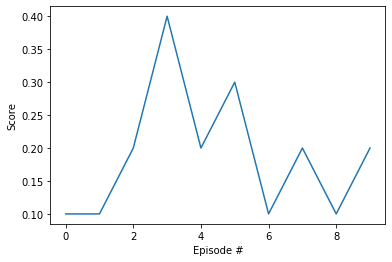

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_list)), scores_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()

#### Ideas for Future Work

Some improvements could be added in order to make learning convergence more stable and fast, such as the use of Epsilon on noise injection (to gradually reduce noise and thus the exploration). Some strategies pointed on paper *Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments* would also be worth trying.